In [27]:
from google.colab import drive
drive.mount('/content/drive')
!gdown --id 1kjibfwQkjNqtQYz0LN8hwI6S5WQDYxY4
!wget https://drive.google.com/file/d/1zHdG8ybERYJnZ1T9vvL8lio2BZdGZVkK/view?usp=share_link
!gdown --id 1--LnQezgO82seZJBvxnVLPulwQfVC-Hx
!mkdir data
!mkdir data/words
!tar -xf iam_words.tgz -C data/words
!mv words.txt data

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [1]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [3]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [4]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [5]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))



In [6]:

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [7]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [8]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [10]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

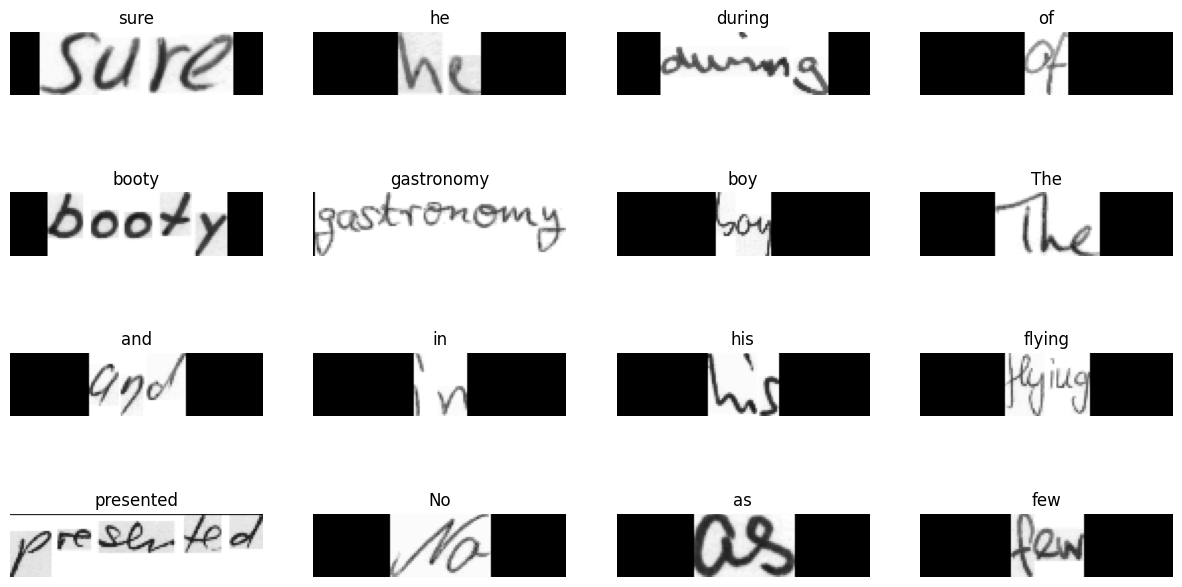

In [11]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [12]:

# class CTCLayer(keras.layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)
#         self.add_loss(loss)

#         # At test time, just return the computed predictions.
#         return y_pred
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred
        
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [13]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [14]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [15]:
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)
cp_checkpoint = ModelCheckpoint("my_model_final",  save_best_only=True,verbose=1)
callbackss=[edit_distance_callback,cp_checkpoint]


In [ ]:
from keras.callbacks import ModelCheckpoint
epochs = 60  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)
cp_checkpoint = ModelCheckpoint("my_model_final",  save_best_only=True,verbose=1)
callbackss=[edit_distance_callback,cp_checkpoint]


# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=callbackss,
)
model.save("final_save.h5")
model.save("model_final")

Epoch 1/60
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 20.4422

Epoch 1: val_loss improved from inf to 11.97911, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 494s 358ms/step - loss: 13.5761 - val_loss: 11.9791
Epoch 2/60
1/1 [==============================] - 0s 42ms/step
Mean edit distance for epoch 2: 20.1418

Epoch 2: val_loss improved from 11.97911 to 10.05196, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 355s 262ms/step - loss: 10.9032 - val_loss: 10.0520
Epoch 3/60
1/1 [==============================] - 0s 52ms/step
Mean edit distance for epoch 3: 19.8811

Epoch 3: val_loss improved from 10.05196 to 8.49429, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 448s 330ms/step - loss: 9.2932 - val_loss: 8.4943
Epoch 4/60
1/1 [==============================] - 0s 68ms/step
Mean edit distance for epoch 4: 19.3839

Epoch 4: val_loss improved from 8.49429 to 6.80894, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 679s 500ms/step - loss: 7.8570 - val_loss: 6.8089
Epoch 5/60
1/1 [==============================] - 0s 75ms/step
Mean edit distance for epoch 5: 18.6942

Epoch 5: val_loss improved from 6.80894 to 5.38698, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 829s 611ms/step - loss: 6.5739 - val_loss: 5.3870
Epoch 6/60
1/1 [==============================] - 0s 79ms/step
Mean edit distance for epoch 6: 18.2883

Epoch 6: val_loss improved from 5.38698 to 4.39745, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 903s 666ms/step - loss: 5.5709 - val_loss: 4.3974
Epoch 7/60
1/1 [==============================] - 0s 78ms/step
Mean edit distance for epoch 7: 18.0784

Epoch 7: val_loss improved from 4.39745 to 3.83845, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 912s 672ms/step - loss: 4.7703 - val_loss: 3.8384
Epoch 8/60
1/1 [==============================] - 0s 71ms/step
Mean edit distance for epoch 8: 17.8989

Epoch 8: val_loss improved from 3.83845 to 3.35430, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 939s 692ms/step - loss: 4.2471 - val_loss: 3.3543
Epoch 9/60
1/1 [==============================] - 0s 88ms/step
Mean edit distance for epoch 9: 17.8178

Epoch 9: val_loss improved from 3.35430 to 3.07825, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1026s 756ms/step - loss: 3.8786 - val_loss: 3.0782
Epoch 10/60
1/1 [==============================] - 0s 105ms/step
Mean edit distance for epoch 10: 17.7946

Epoch 10: val_loss improved from 3.07825 to 2.90784, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1805s 1s/step - loss: 3.6066 - val_loss: 2.9078
Epoch 11/60
1/1 [==============================] - 0s 98ms/step
Mean edit distance for epoch 11: 17.7578

Epoch 11: val_loss improved from 2.90784 to 2.77997, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1086s 800ms/step - loss: 3.3841 - val_loss: 2.7800
Epoch 12/60
1/1 [==============================] - 0s 104ms/step
Mean edit distance for epoch 12: 17.6625

Epoch 12: val_loss improved from 2.77997 to 2.58049, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1071s 789ms/step - loss: 3.2083 - val_loss: 2.5805
Epoch 13/60
1/1 [==============================] - 0s 98ms/step
Mean edit distance for epoch 13: 17.6249

Epoch 13: val_loss improved from 2.58049 to 2.48104, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1080s 796ms/step - loss: 3.0500 - val_loss: 2.4810
Epoch 14/60
1/1 [==============================] - 0s 98ms/step
Mean edit distance for epoch 14: 17.6238

Epoch 14: val_loss improved from 2.48104 to 2.47948, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1093s 805ms/step - loss: 2.9407 - val_loss: 2.4795
Epoch 15/60
1/1 [==============================] - 0s 97ms/step
Mean edit distance for epoch 15: 17.5944

Epoch 15: val_loss improved from 2.47948 to 2.38625, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1107s 816ms/step - loss: 2.8210 - val_loss: 2.3863
Epoch 16/60
1/1 [==============================] - 0s 107ms/step
Mean edit distance for epoch 16: 17.5338

Epoch 16: val_loss improved from 2.38625 to 2.28727, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1129s 832ms/step - loss: 2.7227 - val_loss: 2.2873
Epoch 17/60
1/1 [==============================] - 0s 116ms/step
Mean edit distance for epoch 17: 17.5687

Epoch 17: val_loss did not improve from 2.28727
1357/1357 [==============================] - 1186s 874ms/step - loss: 2.6427 - val_loss: 2.2925
Epoch 18/60
1/1 [==============================] - 0s 117ms/step
Mean edit distance for epoch 18: 17.5319

Epoch 18: val_loss improved from 2.28727 to 2.25867, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1212s 893ms/step - loss: 2.5580 - val_loss: 2.2587
Epoch 19/60
1/1 [==============================] - 0s 121ms/step
Mean edit distance for epoch 19: 17.4815

Epoch 19: val_loss improved from 2.25867 to 2.14200, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1252s 923ms/step - loss: 2.5050 - val_loss: 2.1420
Epoch 20/60
1/1 [==============================] - 0s 125ms/step
Mean edit distance for epoch 20: 17.4916

Epoch 20: val_loss improved from 2.14200 to 2.08701, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1343s 990ms/step - loss: 2.4307 - val_loss: 2.0870
Epoch 21/60
1/1 [==============================] - 0s 126ms/step
Mean edit distance for epoch 21: 17.4934

Epoch 21: val_loss did not improve from 2.08701
1357/1357 [==============================] - 1331s 981ms/step - loss: 2.3801 - val_loss: 2.1210
Epoch 22/60
1/1 [==============================] - 0s 128ms/step
Mean edit distance for epoch 22: 17.4410

Epoch 22: val_loss improved from 2.08701 to 2.04274, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1381s 1s/step - loss: 2.3378 - val_loss: 2.0427
Epoch 23/60
1/1 [==============================] - 0s 124ms/step
Mean edit distance for epoch 23: 17.4368

Epoch 23: val_loss improved from 2.04274 to 2.01727, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1350s 995ms/step - loss: 2.2874 - val_loss: 2.0173
Epoch 24/60
1/1 [==============================] - 0s 126ms/step
Mean edit distance for epoch 24: 17.4249

Epoch 24: val_loss improved from 2.01727 to 1.98829, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1359s 1s/step - loss: 2.2389 - val_loss: 1.9883
Epoch 25/60
1/1 [==============================] - 0s 137ms/step
Mean edit distance for epoch 25: 17.4337

Epoch 25: val_loss did not improve from 1.98829
1357/1357 [==============================] - 1357s 1s/step - loss: 2.1978 - val_loss: 2.0137
Epoch 26/60
1/1 [==============================] - 0s 130ms/step
Mean edit distance for epoch 26: 17.3947

Epoch 26: val_loss improved from 1.98829 to 1.91030, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1372s 1s/step - loss: 2.1741 - val_loss: 1.9103
Epoch 27/60
1/1 [==============================] - 0s 127ms/step
Mean edit distance for epoch 27: 17.4309

Epoch 27: val_loss did not improve from 1.91030
1357/1357 [==============================] - 1349s 994ms/step - loss: 2.1352 - val_loss: 1.9672
Epoch 28/60
1/1 [==============================] - 0s 127ms/step
Mean edit distance for epoch 28: 17.4332

Epoch 28: val_loss did not improve from 1.91030
1357/1357 [==============================] - 1353s 997ms/step - loss: 2.0930 - val_loss: 1.9871
Epoch 29/60
1/1 [==============================] - 0s 128ms/step
Mean edit distance for epoch 29: 17.3983

Epoch 29: val_loss improved from 1.91030 to 1.88904, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1370s 1s/step - loss: 2.0553 - val_loss: 1.8890
Epoch 30/60
1/1 [==============================] - 0s 131ms/step
Mean edit distance for epoch 30: 17.3700

Epoch 30: val_loss did not improve from 1.88904
1357/1357 [==============================] - 1357s 1000ms/step - loss: 2.0383 - val_loss: 1.8956
Epoch 31/60
1/1 [==============================] - 0s 136ms/step
Mean edit distance for epoch 31: 17.4009

Epoch 31: val_loss did not improve from 1.88904
1357/1357 [==============================] - 1362s 1s/step - loss: 1.9967 - val_loss: 1.9037
Epoch 32/60
1/1 [==============================] - 0s 136ms/step
Mean edit distance for epoch 32: 17.3730

Epoch 32: val_loss improved from 1.88904 to 1.88634, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1374s 1s/step - loss: 1.9759 - val_loss: 1.8863
Epoch 33/60
1/1 [==============================] - 0s 133ms/step
Mean edit distance for epoch 33: 17.4033

Epoch 33: val_loss improved from 1.88634 to 1.88585, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1392s 1s/step - loss: 1.9368 - val_loss: 1.8859
Epoch 34/60
1/1 [==============================] - 0s 136ms/step
Mean edit distance for epoch 34: 17.3555

Epoch 34: val_loss improved from 1.88585 to 1.85097, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1424s 1s/step - loss: 1.9350 - val_loss: 1.8510
Epoch 35/60
1/1 [==============================] - 0s 147ms/step
Mean edit distance for epoch 35: 17.3632

Epoch 35: val_loss did not improve from 1.85097
1357/1357 [==============================] - 1464s 1s/step - loss: 1.9034 - val_loss: 1.8548
Epoch 36/60
1/1 [==============================] - 0s 146ms/step
Mean edit distance for epoch 36: 17.3612

Epoch 36: val_loss improved from 1.85097 to 1.81965, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1487s 1s/step - loss: 1.8851 - val_loss: 1.8197
Epoch 37/60
1/1 [==============================] - 0s 145ms/step
Mean edit distance for epoch 37: 17.3802

Epoch 37: val_loss did not improve from 1.81965
1357/1357 [==============================] - 1470s 1s/step - loss: 1.8552 - val_loss: 1.8313
Epoch 38/60
1/1 [==============================] - 0s 144ms/step
Mean edit distance for epoch 38: 17.3542

Epoch 38: val_loss improved from 1.81965 to 1.80403, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1492s 1s/step - loss: 1.8311 - val_loss: 1.8040
Epoch 39/60
1/1 [==============================] - 0s 155ms/step
Mean edit distance for epoch 39: 17.3535

Epoch 39: val_loss improved from 1.80403 to 1.78847, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1502s 1s/step - loss: 1.8094 - val_loss: 1.7885
Epoch 40/60
1/1 [==============================] - 0s 149ms/step
Mean edit distance for epoch 40: 17.3515

Epoch 40: val_loss did not improve from 1.78847
1357/1357 [==============================] - 1508s 1s/step - loss: 1.7938 - val_loss: 1.8029
Epoch 41/60
1/1 [==============================] - 0s 151ms/step
Mean edit distance for epoch 41: 17.3349

Epoch 41: val_loss improved from 1.78847 to 1.75807, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1529s 1s/step - loss: 1.7880 - val_loss: 1.7581
Epoch 42/60
1/1 [==============================] - 0s 162ms/step
Mean edit distance for epoch 42: 17.3496

Epoch 42: val_loss did not improve from 1.75807
1357/1357 [==============================] - 1601s 1s/step - loss: 1.7621 - val_loss: 1.8451
Epoch 43/60
1/1 [==============================] - 0s 158ms/step
Mean edit distance for epoch 43: 17.3298

Epoch 43: val_loss improved from 1.75807 to 1.73438, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1623s 1s/step - loss: 1.7328 - val_loss: 1.7344
Epoch 44/60
1/1 [==============================] - 0s 162ms/step
Mean edit distance for epoch 44: 17.3344

Epoch 44: val_loss did not improve from 1.73438
1357/1357 [==============================] - 1596s 1s/step - loss: 1.7284 - val_loss: 1.7596
Epoch 45/60
1/1 [==============================] - 0s 175ms/step
Mean edit distance for epoch 45: 17.3329

Epoch 45: val_loss did not improve from 1.73438
1357/1357 [==============================] - 1593s 1s/step - loss: 1.7606 - val_loss: 1.7421
Epoch 46/60
1/1 [==============================] - 0s 169ms/step
Mean edit distance for epoch 46: 17.3344

Epoch 46: val_loss improved from 1.73438 to 1.73121, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1642s 1s/step - loss: 1.6952 - val_loss: 1.7312
Epoch 47/60
1/1 [==============================] - 0s 171ms/step
Mean edit distance for epoch 47: 17.3278

Epoch 47: val_loss did not improve from 1.73121
1357/1357 [==============================] - 1647s 1s/step - loss: 1.6863 - val_loss: 1.7541
Epoch 48/60
1/1 [==============================] - 0s 178ms/step
Mean edit distance for epoch 48: 17.3425

Epoch 48: val_loss did not improve from 1.73121
1357/1357 [==============================] - 1655s 1s/step - loss: 1.6848 - val_loss: 1.7513
Epoch 49/60
1/1 [==============================] - 0s 180ms/step
Mean edit distance for epoch 49: 17.3383

Epoch 49: val_loss did not improve from 1.73121
1357/1357 [==============================] - 1661s 1s/step - loss: 1.6652 - val_loss: 1.7528
Epoch 50/60
1/1 [==============================] - 0s 180ms/step
Mean edit distance for epoch 50: 17.3233

Epoch 50: val_loss improved from 1.73121 to 1.71159, sav

INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1673s 1s/step - loss: 1.6823 - val_loss: 1.7116
Epoch 51/60
1/1 [==============================] - 0s 185ms/step
Mean edit distance for epoch 51: 17.3448

Epoch 51: val_loss did not improve from 1.71159
1357/1357 [==============================] - 1707s 1s/step - loss: 1.6435 - val_loss: 1.7604
Epoch 52/60
1/1 [==============================] - 0s 186ms/step
Mean edit distance for epoch 52: 17.3264

Epoch 52: val_loss did not improve from 1.71159
1357/1357 [==============================] - 1733s 1s/step - loss: 1.6255 - val_loss: 1.7312
Epoch 53/60
1/1 [==============================] - 0s 183ms/step
Mean edit distance for epoch 53: 17.3158

Epoch 53: val_loss did not improve from 1.71159
1357/1357 [==============================] - 1709s 1s/step - loss: 1.6185 - val_loss: 1.7553
Epoch 54/60
1/1 [==============================] - 0s 226ms/step
Mean edit distance for epoch 54: 17.3132

Epoch 54: val_loss improved from 1.71159 to 1.70459, sav

INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1742s 1s/step - loss: 1.6026 - val_loss: 1.7046
Epoch 55/60
1/1 [==============================] - 0s 182ms/step
Mean edit distance for epoch 55: 17.3407

Epoch 55: val_loss did not improve from 1.70459
1357/1357 [==============================] - 1712s 1s/step - loss: 1.5896 - val_loss: 1.7662
Epoch 56/60
1/1 [==============================] - 0s 215ms/step
Mean edit distance for epoch 56: 17.3210

Epoch 56: val_loss did not improve from 1.70459
1357/1357 [==============================] - 1728s 1s/step - loss: 1.5992 - val_loss: 1.7464
Epoch 57/60
1/1 [==============================] - 0s 181ms/step
Mean edit distance for epoch 57: 17.3189

Epoch 57: val_loss did not improve from 1.70459
1357/1357 [==============================] - 1720s 1s/step - loss: 1.5861 - val_loss: 1.7429
Epoch 58/60
1/1 [==============================] - 0s 182ms/step
Mean edit distance for epoch 58: 17.3159

Epoch 58: val_loss did not improve from 1.70459
1357/135

INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1739s 1s/step - loss: 1.5730 - val_loss: 1.7018
Epoch 60/60
1/1 [==============================] - 0s 179ms/step
Mean edit distance for epoch 60: 17.2997

Epoch 60: val_loss improved from 1.70185 to 1.70021, saving model to my_model_final


INFO:tensorflow:Assets written to: my_model_final\assets


INFO:tensorflow:Assets written to: my_model_final\assets


1357/1357 [==============================] - 1754s 1s/step - loss: 1.5508 - val_loss: 1.7002


INFO:tensorflow:Assets written to: model_final\assets


INFO:tensorflow:Assets written to: model_final\assets


In [16]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



2/2 [==============================] - 3s 51ms/step


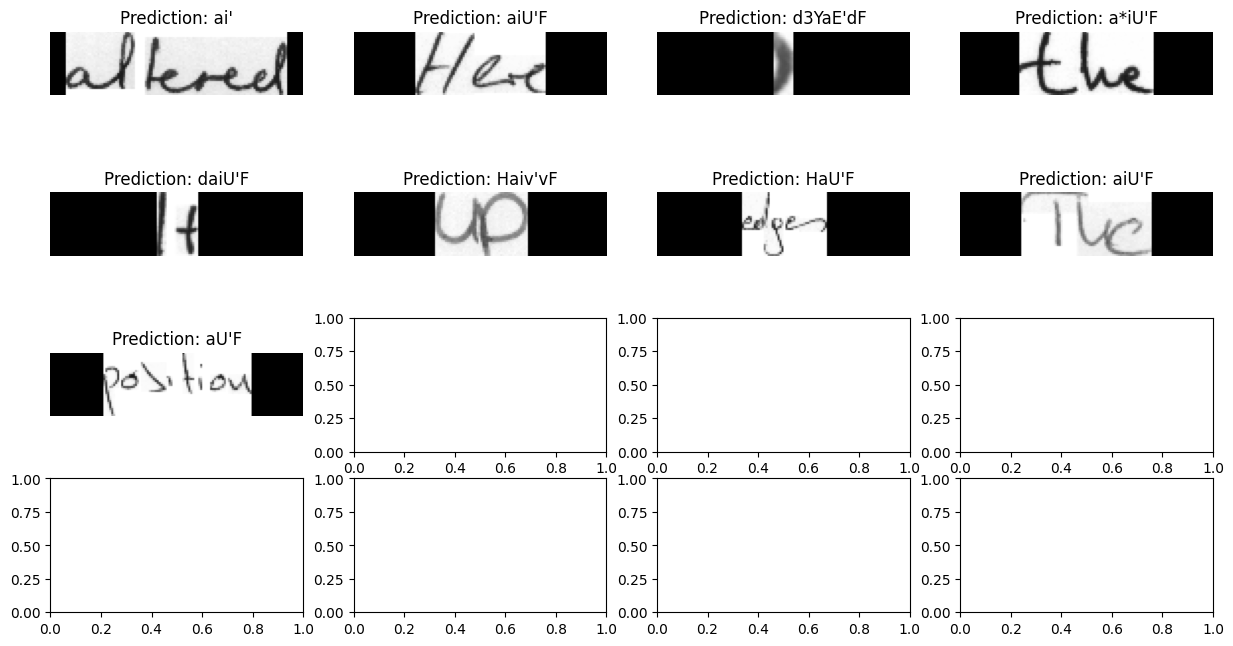

In [17]:

#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(9):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [18]:
new_model = tf.keras.models.load_model("model_final")
new_model1 = tf.keras.models.load_model("my_model_final")
new_model2 = tf.keras.models.load_model("final_save.h5",custom_objects={"CTCLayer": CTCLayer})



In [19]:
new_model2.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [20]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

path = "segmented/"

counter = sorted_alphanumeric(os.listdir('segmented'))

for x in range(len(counter)):
    counter[x] = os.path.join(path, counter[x])

num = len(counter)

In [25]:
batch_size = num
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image1(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_images_labels1(image_path):
    image = preprocess_image1(image_path)

    return {"image": image}


def prepare_dataset1(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
        process_images_labels1, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

(108, 128, 32, 1)
Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496 

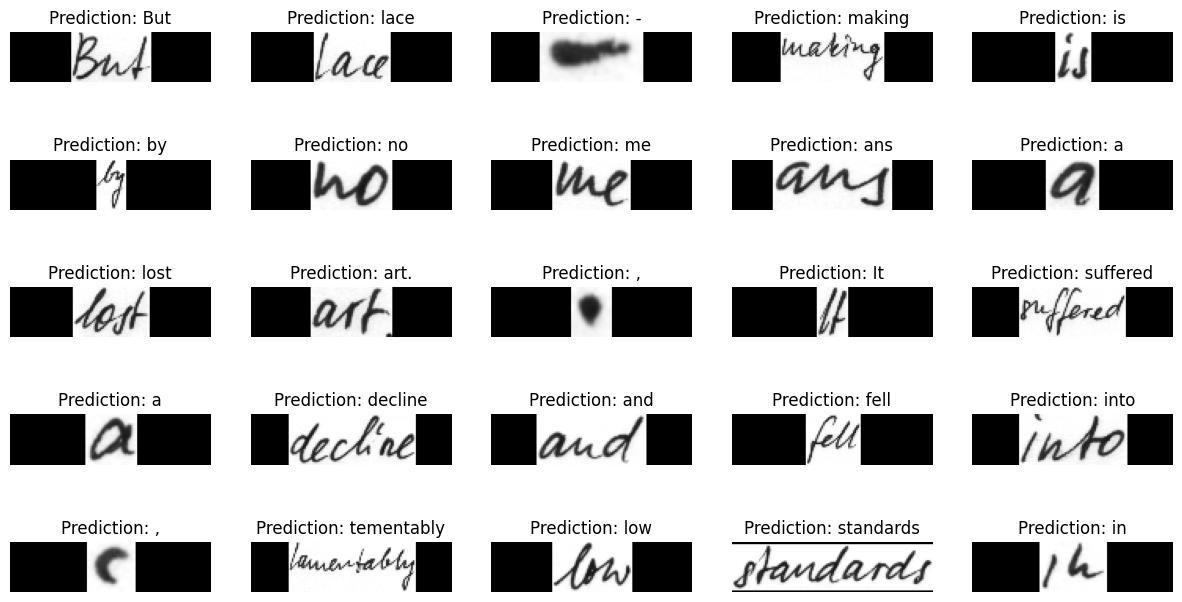

In [30]:

ocr_test_img_path = counter

test_ds1 = prepare_dataset1(ocr_test_img_path)

for batch in test_ds1.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    print(batch_images.shape)
    new_model.summary()
    batch_labels = np.zeros((num, 90))

    preds = new_model.predict([batch_images,batch_labels])
    pred_texts = decode_batch_predictions(preds)
    for i in range(25):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(title)
        ax[i // 5, i % 5].axis("off")
plt.show()
file = open('items.txt','w').close()
file = open('items.txt','w')

for item in pred_texts:
    file.write(item + " ")

file.close()


In [ ]:
ocr_test_img_path=['data/ocr_test/word1.png','data/ocr_test/word2.png','data/ocr_test/word3.png','data/ocr_test/word4.png','data/ocr_test/word5.png','data/ocr_test/word6.png','data/ocr_test/word7.png','data/ocr_test/word8.png','data/ocr_test/word9.png']

for batch in ocr_test_img_path:
  
    print(batch)

data/ocr_test/word1.png
data/ocr_test/word2.png
data/ocr_test/word3.png
data/ocr_test/word4.png
data/ocr_test/word5.png
data/ocr_test/word6.png
data/ocr_test/word7.png
data/ocr_test/word8.png
data/ocr_test/word9.png


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')